In [12]:
import json

In [13]:
data = {}
data['area']='classifier_models/models_for_area/checkpoint-26750'
data['customer_rating']='classifier_models/models_for_customer_rating/checkpoint-11992'
data['name']='classifier_models/models_for_name/checkpoint-16766'
data['near']='classifier_models/models_for_near/checkpoint-4530'
data['Type']='classifier_models/models_for_Type/checkpoint-3017'
data['food']='classifier_models/models_for_food/checkpoint-7066'
data['price']='classifier_models/models_for_price/checkpoint-6113'
data['family_friendly']='classifier_models/models_for_family_friendly/checkpoint-5575'


with open('classifier_models/model_paths.json', 'w') as f:
    json.dump(data, f)

In [71]:
data = {}
# data['area']='bert_classifier_models/models_for_area/checkpoint-26750'

data['customer_rating']='bert_classifier_models/models_for_customer_rating/checkpoint-26094'
data['name']='bert_classifier_models/models_for_name/checkpoint-36328'
data['near']='bert_classifier_models/models_for_near/checkpoint-19728'
# data['Type']='bert_classifier_models/models_for_Type/checkpoint-3017'
# data['food']='bert_classifier_models/models_for_food/checkpoint-7066'
data['price']='bert_classifier_models/models_for_price/checkpoint-26559'
# data['family_friendly']='bert_classifier_models/models_for_family_friendly/checkpoint-5575'


with open('bert_classifier_models/model_paths.json', 'w') as f:
    json.dump(data, f)

In [43]:
from controlled_text_generation import *

In [44]:
model_paths=read_json('classifier_models/model_paths.json')

In [45]:
control_list=model_paths.keys()

In [46]:
label2id_dict,id2label_dict=read_all_label_maps(control_list)
print(label2id_dict.keys())
print(id2label_dict.keys())

dict_keys(['area', 'customer_rating', 'name', 'near', 'Type'])
dict_keys(['area', 'customer_rating', 'name', 'near', 'Type'])


In [6]:
INPUT_PATH='dataset/e2e_data/src1_valid.txt'
input_data=get_parsed_input_data(INPUT_PATH)


Reading input file from dataset/e2e_data/src1_valid.txt...


In [7]:
input_data[:3]

[{'name': 'Alimentum', 'area': 'city centre', 'family friendly': 'no'},
 {'name': 'Alimentum', 'area': 'city centre', 'family friendly': 'no'},
 {'name': 'Alimentum', 'area': 'city centre', 'family friendly': 'no'}]

In [8]:
n_labels_dict={}
for control_name in control_list:
    n_labels_dict[control_name]=len(label2id_dict[control_name])
print(n_labels_dict)


{'area': 2, 'customer_rating': 6, 'name': 34, 'near': 19, 'Type': 3}


In [104]:
# classifier_data=collect_classifiers(control_list,n_labels_dict)
# model,tokenizer=get_classifier(model_paths['Type'],n_labels_dict['Type'],device='cpu')
# 'classifier_models/models_for_Type/checkpoint-3017'
model,tokenizer=get_classifier('classifier_models/models_for_Type/checkpoint-3017',n_labels_dict['Type'],device='cpu')

-------------------------------
Accessing model from  classifier_models/models_for_Type/checkpoint-3017
Loading configuraiton..
Loading tokenizer...
Loading model...
Model loaded to `cpu`
-------------------------------


In [48]:
classifier_data=collect_classifiers(control_list,n_labels_dict,device='cpu')


-------------------------------
Accessing model from  classifier_models/models_for_area/checkpoint-5350
Loading configuraiton..
Loading tokenizer...
Loading model...
Model loaded to `cpu`
-------------------------------
-------------------------------
Accessing model from  classifier_models/models_for_customer_rating/checkpoint-11992
Loading configuraiton..
Loading tokenizer...
Loading model...
Model loaded to `cpu`
-------------------------------
-------------------------------
Accessing model from  classifier_models/models_for_name/checkpoint-16766
Loading configuraiton..
Loading tokenizer...
Loading model...
Model loaded to `cpu`
-------------------------------
-------------------------------
Accessing model from  classifier_models/models_for_near/checkpoint-4530
Loading configuraiton..
Loading tokenizer...
Loading model...
Model loaded to `cpu`
-------------------------------
-------------------------------
Accessing model from  classifier_models/models_for_Type/checkpoint-16092
Lo

In [13]:
classifier_data.keys()

dict_keys(['area', 'customer_rating', 'name', 'near', 'Type'])

In [49]:
def get_classifier_logits(classifer_model,classifier_tokenizer,text,id2label,label2id):
  encoding = classifier_tokenizer(text, return_tensors="pt")
  encoding = {k: v.to(classifer_model.device) for k,v in encoding.items()}

  outputs = classifer_model(**encoding) 
  
  logits = outputs.logits
  # apply sigmoid + threshold
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(logits.squeeze().cpu())
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs >= 0.5)] = 1
  # turn predicted id's into actual label names
  predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
  # print(predicted_labels)

  return logits

In [17]:
text='Zizzi is a family-friendly cafe. It is near the city-centre.'

In [87]:
id2label=id2label_dict['Type']
label2id=label2id_dict['Type']

In [31]:
logits=get_classifier_logits(model,tokenizer,text,id2label_dict['Type'],label2id_dict['Type'])

In [19]:
id2label_dict['area']

{0: 'riverside', 1: 'city centre'}

In [28]:
label2id

{'riverside': 0, 'city centre': 1}

In [34]:
logits

tensor([[-2.4331, -0.1024]], grad_fn=<SubBackward0>)

In [32]:
logits=logits-torch.log(1+torch.exp(logits))

In [33]:
logits

tensor([[-2.4331, -0.1024]], grad_fn=<SubBackward0>)

In [ ]:
model

# Testing the classifers

area based classifier : Correct = 23884/24716



In [89]:
def get_label_text(input_path):
    input_data=[]
    text_data=[]
    with open(input_path, 'r') as ff:
        for row in ff:
            word_lst = row.split('||')[1]
            label_mapping=split_label(row.split('||')[0])
            input_data.append(label_mapping)
            text_data.append(word_lst)
    
    return input_data,text_data

In [118]:
label_data_train,text_data_train=get_label_text('dataset/e2e_data/src1_train.txt')

In [100]:

def get_classifier_report(class_checked,label_data_train,text_data_train,model,tokenizer,id2label,label2id):
    total=0
    correct=0
    incorrect=[]
    for labels,text in zip(label_data_train,text_data_train):
        # print("text: ",text)
        # print("label : ",labels)
        if class_checked not in labels :
            continue
        logits=get_classifier_logits(model,tokenizer,text,id2label,label2id)
        print("classifier : ",logits)
        pred=id2label[np.argmax(logits.detach().numpy()[0])]
        # print("prediction : ",pred)
        total+=1
        if pred==labels[class_checked]:
            correct+=1
        else :
            print(text.strip())
            print(labels[class_checked])
            print(pred)
            print('--------')
            incorrect.append((text,labels))

    print("Correct = {}/{}".format(correct,total))
    print("Incorrect : ")
    # for i in incorrect:
    #     print(i[1])
    #     print(i[0])
        

In [119]:
get_classifier_report('Type',label_data_train,text_data_train,model,tokenizer,id2label,label2id)

classifier :  tensor([[ 3.2057, -0.1602,  0.7605]], grad_fn=<IndexBackward0>)
classifier :  tensor([[ 3.8667,  2.0850, -1.3021]], grad_fn=<IndexBackward0>)
classifier :  tensor([[-0.6256,  4.7945, -3.5962]], grad_fn=<IndexBackward0>)
classifier :  tensor([[-1.6398,  2.5916, -1.8463]], grad_fn=<IndexBackward0>)
classifier :  tensor([[-1.5551,  2.3919, -1.0433]], grad_fn=<IndexBackward0>)
classifier :  tensor([[-0.6768,  3.7978, -3.0154]], grad_fn=<IndexBackward0>)
classifier :  tensor([[ 1.0342,  2.6775, -0.2061]], grad_fn=<IndexBackward0>)
A child friendly restaurant that has English food is Loch Fyne .
restaurant
coffee shop
--------
classifier :  tensor([[0.2778, 1.1995, 0.3288]], grad_fn=<IndexBackward0>)
Taste of Cambridge is a restaurant with a customer rating of 3 out of 5 and and a price range of £ 20- £ 25
restaurant
coffee shop
--------
classifier :  tensor([[-0.4035,  2.8978, -1.3532]], grad_fn=<IndexBackward0>)
classifier :  tensor([[-0.1701,  0.4396,  1.8969]], grad_fn=<Ind

# Condition Strengthing 

In [65]:
import matplotlib.pyplot as plt

In [74]:
before=[0.0294, 0.0602, 0.1959, 0.1303, 0.0614, 0.0483, 0.0706, 0.1001, 0.2915,0.0122]
after=[3.0235e-05, 1.6424e-04, 2.0285e-04, 7.6389e-14, 9.2735e-03, 3.9559e-04,
        8.2136e-02, 8.4798e-01, 5.9818e-02, 1.0730e-16]

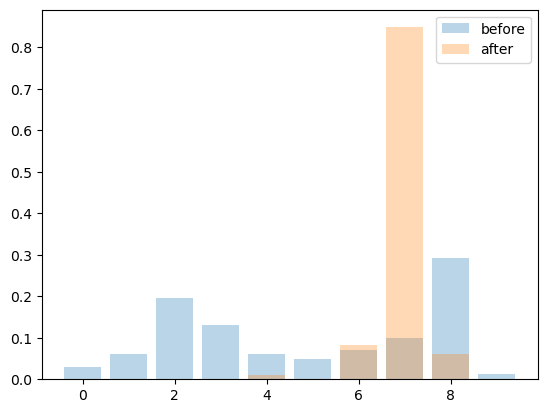

In [83]:
plt.bar(x=list(range(10)),height=before,label='before',alpha=0.3)
plt.bar(x=list(range(10)),height=after,label='after',alpha=0.3)
plt.legend()

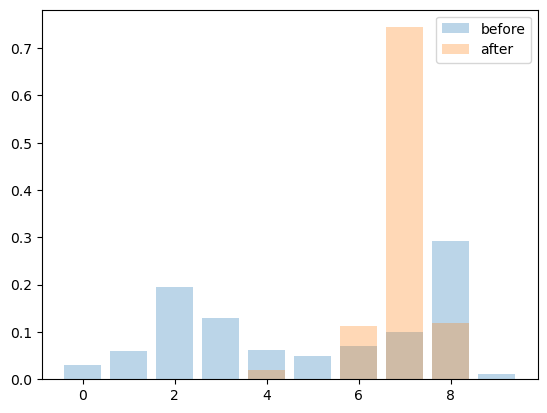

In [85]:
before=[0.0294, 0.0602, 0.1959, 0.1303, 0.0614, 0.0483, 0.0706, 0.1001, 0.2915,
        0.0122]
after=[1.9669e-04, 8.6029e-04, 1.3179e-03, 5.6317e-11, 1.9907e-02, 1.6234e-03,
        1.1204e-01, 7.4407e-01, 1.1998e-01, 2.0127e-13]
plt.bar(x=list(range(10)),height=before,label='before',alpha=0.3)
plt.bar(x=list(range(10)),height=after,label='after',alpha=0.3)
plt.legend()

# Report Files

In [49]:
from controlled_text_generation import *

In [50]:
report_Type=read_json('classifier_models/models_for_Type/report.json')

In [51]:
def best_report(path):   
    report_data=read_json(path) 
    acc=0
    best_model=''
    for model_path in report_data:
        # print(model_path)
        if report_data[model_path]['test']['accuracy']>acc :
            acc=report_data[model_path]['test']['accuracy']
            best_model=model_path
        # print("train accuracy {:.2f}".format(report_data[model_path]['train']['accuracy']))
        # print("test accuracy {:.2f}".format(report_data[model_path]['test']['accuracy']))
        # print("valid accuracy {:.2f}".format(report_data[model_path]['valid']['accuracy']))
    
    print("Best Report : {} acc={:.2f}".format(best_model,100*acc))

In [52]:
best_report('classifier_models/models_for_area/report.json')
best_report('classifier_models/models_for_food/report.json')
best_report('classifier_models/models_for_family_friendly/report.json')
best_report('classifier_models/models_for_Type/report.json') # this has to be updated
# best_report('classifier_models/models_for_customer_rating/report.json')
best_report('classifier_models/models_for_name/report.json') 
best_report('classifier_models/models_for_price/report.json') 


Best Report : classifier_models/models_for_area/checkpoint-26750 acc=97.30
Best Report : classifier_models/models_for_food/checkpoint-14132 acc=64.80
Best Report : classifier_models/models_for_family_friendly/checkpoint-16725 acc=92.78
Best Report : classifier_models/models_for_Type/checkpoint-12069 acc=46.62
Best Report : classifier_models/models_for_name/checkpoint-25149 acc=12.76
Best Report : classifier_models/models_for_price/checkpoint-6113 acc=60.25


# Read Test file from diffusion-lm repo

In [1]:
import json

In [3]:
path='../Diffusion-LM/datasets/control_target/target_attribute.json'

In [4]:
data = []
with open(path) as f:
    for line in f:
        data.append(json.loads(line))

In [8]:
path.endswith('.json')

True

In [19]:
for x in data:
    print(x)

area
customer_rating
name
near
Type
food
price
family_friendly


In [15]:
"name"+":"+"The Valuts"+"||"

'name:The Valuts||'

In [67]:
path='generated_output/bert_controlled_generation_n_lm_10_lambda_4_sample_strat_max.txt'

data={}
with open(path) as f:
    for line in f:
        info=line.split("||")
        label=info[0]
        if ":" not in line:
            continue
        control=label.split(":")[0].strip()
        print(label.split(":"))
        val=label.split(":")[1].strip()
        key_=[control,val]
        text=info[1]
        if label in data:
            data[label].append(text)
        else:
            data[label]=[text]
        
        

['name', 'The Vaults']
['name', 'The Cambridge Blue']
['name', 'The Eagle']
['name', 'The Mill']
['name', 'Loch Fyne']
['name', 'Bibimbap House']
['name', 'The Rice Boat']
['name', 'The Wrestlers']
['name', 'Aromi']
['name', 'The Phoenix']
['name', 'Browns Cambridge']
['name', 'Taste of Cambridge']
['name', 'Cocum']
['name', 'The Dumpling Tree']
['name', 'The Punter']
['name', 'The Golden Curry']
['name', 'Alimentum']
['name', 'Midsummer House']
['name', 'Blue Spice']
['name', 'Strada']
['name', 'The Waterman']
['name', 'Zizzi']
['name', 'Green Man']
['name', 'Clowns']
['name', 'Giraffe']
['name', 'The Olive Grove']
['name', 'The Twenty Two']
['name', 'The Cricketers']
['name', 'Wildwood']
['name', 'The Golden Palace']
['name', 'The Plough']
['name', 'Cotto']
['name', 'Fitzbillies']
['name', 'Travellers Rest Beefeater']
['Type', 'pub']
['Type', 'coffee shop']
['Type', 'restaurant']
['area', 'riverside']
['area', 'city centre']
['customer_rating', '5 out of 5']
['customer_rating', 'low'

In [68]:
# # with open("generated_output/controlled_generation_lambda_1_max.json", "w") as outfile:
# #     outfile.write(data)
# with open("generated_output/controlled_generation_lambda_1_max.json", "w") as outfile:
#     json.dump(data, outfile)

In [69]:
# import json

# with open('results2.jsonl', 'r') as json_file:
#     json_list = list(json_file)


In [ ]:

count_correct = 0
count_total = 0

for json_str in json_list:
    entry = json.loads(json_str)
    for key in entry.keys():
        control = key[key.rfind(':')+4:-1].split(', ')
        for i in range(len(control)):
            control[i] = control[i][1:-1]
        control_string = ''
        for word in control:
            control_string += word
            control_string += ' '
        control_string = control_string[:-1]
        for i in range(len(entry[key])):
            count_total += 1
            if control_string in entry[key][i]:
                count_correct += 1

print(count_correct/count_total)

In [70]:
total=0
correct=0
incorrect=[]
for key in data :
    text=data[key]
    value=key.split(":")[1]
    
    # print(value)
    # print(text)
    for txt in text:
        total+=1
        if value in txt:
            correct+=1
        else :
            # print("Val = ",value)
            incorrect.append((value,txt))

print(correct/total)


0.379746835443038


In [64]:
incorrect[-10:]

[('yes',
  ' Coffee Shop is a family friendly coffee shop located near the riverside. \n'),
 ('no',
  ' The Eagle is a moderately priced restaurant located near Café Sicilia. \n'),
 ('English',
  ' A family friendly coffee shop near the riverside is The Rice Boat. \n'),
 ('French',
  ' The Waterman is a Japanese restaurant located near Café Rouge. It is family friendly and has a customer rating of 5 out of 5. \n'),
 ('Fast food', ' A coffee shop is located near the riverside. \n'),
 ('Italian',
  ' Cinema is located near the riverside. It is family friendly and has a low customer rating. \n'),
 ('Chinese',
  ' Located in riverside, The Punter is a children - friendly restaurant. \n'),
 ('more than £ 30',
  ' Located near Café Rouge, The Waterman is a coffee shop that serves Japanese food. \n'),
 ('£ 20 - 25',
  ' The Golden Curry is a coffee shop, located near Café Sicilia. \n'),
 ('high', ' <|endoftext|> \n')]

# Convert control gen to perplexity_input


In [72]:
def get_lines(file_path):
    lines=[]
    with open(file_path) as f:
        for line in f:
            lines.append(line)
    
    return lines

In [74]:
input_control_file='generated_output/bert_controlled_generation_n_lm_10_lambda_3_sample_strat_max.txt'

In [75]:
file_data=get_lines(input_control_file)

In [80]:
eos_tag="<|endoftext|>"

In [81]:
file_data[0].strip().split("||")[1].strip()+" "+eos_tag

'A high priced pub with a low customer rating is The Plight. <|endoftext|>'

In [82]:
import os

In [85]:
os.path.split(input_control_file)[-1]

'bert_controlled_generation_n_lm_10_lambda_3_sample_strat_max.txt'

In [88]:
input_control_file.endswith('.txt')

True

In [94]:
with open('generated_output/results2_diffusion_lm_semantic_control.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [ ]:
output_data=[]
for json_str in json_list:
    entry = json.loads(json_str)
    for key in entry.keys():
        for sent in entry[key]:
            print(sent.split())
            new_sent=""
            for i in sent.split():
                if i=='END':
                    output_data.append(sent.strip()+" "+eos_tag)
                    sent=""
                    continue
                elif i=='START':
                    sent=""
                    continue
                sent=sent+" "+i
            


# POS Tagger

In [123]:
from flair.nn import Classifier
from flair.data import Sentence


In [143]:

# load the model
tagger = Classifier.load('upos-fast')


2023-04-12 14:53:42,580 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, VERB, PUNCT, ADP, DET, PROPN, PRON, ADJ, ADV, CCONJ, PART, NUM, AUX, INTJ, SYM, X, <START>, <STOP>


In [177]:

# make a sentence
sentence = Sentence('Alimentum at high prices  for a family atmosphere at the Riverside Inn that can suit the entire Family,')

# predict NER tags
output=tagger.predict(sentence)

# print sentence with predicted tags
print(sentence)

Sentence[19]: "Alimentum at high prices  for a family atmosphere at the Riverside Inn that can suit the entire Family," → ["Alimentum"/X, "at"/X, "high"/X, "prices"/X, "for"/X, "a"/X, "family"/X, "atmosphere"/X, "at"/X, "the"/X, "Riverside"/X, "Inn"/PUNCT, "that"/NOUN, "can"/AUX, "suit"/VERB, "the"/X, "entire"/X, "Family"/X, ","/X]


In [176]:
for token in sentence:
    print(token.tag)

X
X
X
X
X
PUNCT


In [167]:
for token in sentence:  
    prob_dist = token.tags_proba_dist  
    new_prob_dist = {}
    for i in token.tags_proba_dist['upos']:
        new_prob_dist[i.value]=i.score
    print(token,new_prob_dist)
    break
    # new_prob_dist = []  
    # for i in prob_dist['pos-fast']:  
    #     new_prob_dist.append([i.value, i.score])  
    # print(token, new_prob_dist) 

Token[0]: "Dirk" → X (0.718) {'<unk>': 0.00011324553, 'NOUN': 0.009035961, 'VERB': 6.378754e-05, 'PUNCT': 0.0012143408, 'ADP': 1.2184564e-07, 'DET': 1.74357e-05, 'PROPN': 0.7179745, 'PRON': 6.957347e-05, 'ADJ': 0.00021018347, 'ADV': 1.13333845e-05, 'CCONJ': 2.1274593e-05, 'PART': 1.5729332e-06, 'NUM': 0.004113813, 'AUX': 4.2133197e-06, 'INTJ': 0.0020436859, 'SYM': 0.0014871833, 'X': 0.26355147, '<START>': 0.0, '<STOP>': 6.622584e-05}


In [168]:
new_prob_dist['PROPN']

0.7179745

In [169]:
token.score
torch.inf

inf

In [141]:
with open('dataset/control_target/target_pos.json', 'r') as json_file:
    json_list = list(json_file)
    for line in json_list:
        print(json.loads(line)['pos'])

['START', 'ADV', 'NOUN', 'ADV', 'ADP', 'PROPN', 'PROPN', 'PUNCT', 'DET', 'PROPN', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'NOUN', 'CCONJ', 'AUX', 'PART', 'VERB', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'END']
['START', 'PROPN', 'AUX', 'DET', 'ADJ', 'NOUN', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'END']
['START', 'PROPN', 'AUX', 'DET', 'NOUN', 'VERB', 'NOUN', 'ADJ', 'NOUN', 'PUNCT', 'PRON', 'NOUN', 'NOUN', 'AUX', 'ADJ', 'ADP', 'END']
['START', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'VERB', 'ADJ', 'CCONJ', 'ADJ', 'NOUN', 'CCONJ', 'AUX', 'VERB', 'ADP', 'DET', 'PROPN', 'ADJ', 'PROPN', 'PUNCT', 'PROPN', 'END']
['START', 'DET', 'PROPN', 'PROPN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'ADP', 'SYM', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'AUX', 'ADJ', 'PUNCT', 'DET', 'PROPN', 'PROPN', 'AUX', 'VERB', 'ADP', 'DET', 'PROPN', 'CCONJ', 'PROPN', 'ADP', 'PROPN', 'PROPN', 'PUNCT', 'ADJ', 'PUNCT', 'DET', 'NOUN', 'PART', 'AUX', 'VERB', 'PUNCT', 'PROPN', 'END']
['START', 'PROPN', 'PROPN'

In [164]:
json.dump(json.loads(json_list[0]))

TypeError: dump() missing 1 required positional argument: 'fp'

In [28]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp('There is a cheap restaurant in the riverside area near The Rice Boat')
output_sent_pos=[]
for token in doc:
    output_sent_pos.append(token.pos_)

In [4]:
expected_pos=['START', 'PROPN', 'PROPN', 'AUX', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'ADP', 'DET', 'PROPN', 'PUNCT', 'PRON', 'AUX', 'NOUN', 'PUNCT', 'ADJ', 'PUNCT', 'PROPN', 'END']

In [29]:
for i,val in enumerate(output_sent_pos):
    print(val," ",expected_pos[i+1])

NameError: name 'expected_pos' is not defined

In [202]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/upos-multi")

# make example sentence
sentence = Sentence("Ich liebe Berlin, as they say. ")

# predict POS tags
tagger.predict(sentence)

# print sentence
print(sentence)

# iterate over tokens and print the predicted POS label
print("The following POS tags are found:")
for token in sentence:
    print(token.get_label("upos"))


2023-04-13 11:59:45,141 SequenceTagger predicts: Dictionary with 21 tags: <unk>, O, PROPN, PUNCT, ADJ, NOUN, VERB, DET, ADP, AUX, PRON, PART, SCONJ, NUM, ADV, CCONJ, X, INTJ, SYM, <START>, <STOP>
Sentence[8]: "Ich liebe Berlin, as they say." → ["Ich"/PRON, "liebe"/VERB, "Berlin"/PROPN, ","/PUNCT, "as"/SCONJ, "they"/PRON, "say"/VERB, "."/PUNCT]
The following POS tags are found:
Token[0]: "Ich" → PRON (0.9999)
Token[1]: "liebe" → VERB (0.9999)
Token[2]: "Berlin" → PROPN (0.9997)
Token[3]: "," → PUNCT (1.0)
Token[4]: "as" → SCONJ (0.9991)
Token[5]: "they" → PRON (0.9998)
Token[6]: "say" → VERB (0.9998)
Token[7]: "." → PUNCT (1.0)


In [1]:
from scipy.spatial import distance


In [5]:
distance.hamming(output_sent_pos, expected_pos)

ValueError: The 1d arrays must have equal lengths.

In [4]:
"The following POS tags \n are found: \n".strip()

'The following POS tags \n are found:'

# LM output decoding

In [5]:

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import argparse
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import os
import json

In [7]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [18]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)




In [21]:
model = model.to(device)
MODEL_PATH='CTG_pos_control_models/gpt2_e2e_5.pt'
model.load_state_dict(torch.load(MODEL_PATH,map_location=device))

<All keys matched successfully>

In [33]:
input_ids = tokenizer.encode('START PRON VERB DET ADJ ADJ NOUN ADP DET NOUN NOUN ADP DET PROPN END ||', return_tensors='pt')


beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)
greedy_output = model.generate(input_ids, max_length=50)

print("Output GREEDY:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

print("Output SEARCH:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output GREEDY:
----------------------------------------------------------------------------------------------------
START PRON VERB DET ADJ ADJ NOUN ADP DET NOUN NOUN ADP DET PROPN END ||There is a cheap Italian restaurant in the riverside area near The Sorrento
Output SEARCH:
----------------------------------------------------------------------------------------------------
START PRON VERB DET ADJ ADJ NOUN ADP DET NOUN NOUN ADP DET PROPN END ||There is a cheap Italian restaurant in the riverside area near The Sorrento


In [34]:
doc = nlp('There is a cheap Italian restaurant in the riverside area near The Sorrento')
output_sent_pos=[]
for token in doc:
    output_sent_pos.append(token.pos_)
print(output_sent_pos)

['PRON', 'VERB', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'ADP', 'DET', 'PROPN']


# Create file for valid multi-control

In [35]:
input_path='dataset/e2e_data/src1_valid.txt'
controls=[]
with open(input_path, 'r') as ff:
            for row in ff:
                controls.append(row.split("||")[0])

In [38]:
uniq_controls=list(set(controls))

In [40]:
len(uniq_controls)

547

In [56]:
output_file_path='dataset/e2e_data/multicontrol_filter.txt'
with open(output_file_path, 'a') as f:
    for uniq_ctrl in uniq_controls:
        if 'area' in uniq_ctrl and 'name' in uniq_ctrl and 'family' in uniq_ctrl:
            f.write(f"{uniq_ctrl}||\n")

In [44]:
import random

In [46]:
uniq_ctrl_200=random.sample(uniq_controls,200)

In [48]:
def split_label(label_string):
  pair_lst = {x.split(':')[0].lstrip().strip():x.split(':')[1].lstrip().strip() for x in label_string.split('|')}
  return pair_lst

In [52]:
for i in uniq_controls:
    split_label(i)

In [61]:
from controlled_text_generation_v2 import *

In [68]:
type_labels,type_ids=get_label_map('Type')

In [76]:
food_labels,food_ids=get_label_map('food')

In [70]:
area_labels,area_ids=get_label_map('area')

In [73]:
print(type_labels)
print(name_labels)
print(area_labels)

{'pub': 0, 'coffee shop': 1, 'restaurant': 2}
{'English': 0, 'Japanese': 1, 'French': 2, 'Fast food': 3, 'Italian': 4, 'Indian': 5, 'Chinese': 6}
{'riverside': 0, 'city centre': 1}


In [78]:
output_file_path='dataset/e2e_data/multicontrol_filter.txt'
with open(output_file_path, 'a') as f:
    for type_val in type_labels:
        for food_val in food_labels:
            for area_val in area_labels:
                uniq_ctrl=f"Type : {type_val} | food : {food_val} | area : {area_val}"
                f.write(f"{uniq_ctrl}||\n")


# calculating accuracy per control

In [79]:
def read_file_lbyl(path):
    lines=[]
    with open(path) as f:
        for line in f:
            lines.append(line)
    
    return lines

In [80]:

def read_jsonl(path):
    json_list=None
    with open(path, 'r') as json_file:
        json_list = list(json_file)
    return json_list

In [107]:
def get_acc_score_txt(data):   
    count_correct=0
    count_total=0
    control_pair_count={}
    control_pair_total={}
    for line in data:
        if '||' not in line :
            continue

        contrl_pair=line.strip().split("||")[0]
        
        contrl_pair=contrl_pair.split("|")[0]
        txt=line.strip().split("||")[1]
        count_total+=1
        
        contrl=contrl_pair.split(":")[0].strip()
        value=contrl_pair.split(":")[1].strip()
        if contrl in control_pair_total:
            control_pair_total[contrl]+=1
        else :
            control_pair_total[contrl]=1

        # print(value)
        # print(contrl)
        # print(txt)
        if value in txt:
            count_correct+=1
            if contrl in control_pair_count:
                control_pair_count[contrl]+=1
            else :
                control_pair_count[contrl]=1

    print("Accuracy Score : ",100*count_correct/count_total)
    return control_pair_total,control_pair_count

In [90]:
    
def get_acc_score_json(data):
    for json_str in data:
        entry = json.loads(json_str)
        print(entry)
        for key in entry.keys():
            control = key[key.rfind(':')+4:-1].split(', ')
            for i in range(len(control)):
                control[i] = control[i][1:-1]
            control_string = ''
            for word in control:
                control_string += word
                control_string += ' '
            control_string = control_string[:-1]
            for i in range(len(entry[key])):
                count_total += 1
                if control_string in entry[key][i]:
                    count_correct += 1

    print("Accuracy Score : ",100*count_correct/count_total)

In [195]:
file_path='generated_output/bert_controlled_generation_n_lm_10_lambda_3_sample_strat_max.txt'
file_data=read_file_lbyl(file_path)
totals,counts=get_acc_score_txt(file_data)
for ctrl in counts:
    print(ctrl," : ",100*counts[ctrl]/totals[ctrl])

Accuracy Score :  35.44303797468354
name  :  38.23529411764706
Type  :  100.0
customer_rating  :  16.666666666666668
near  :  26.31578947368421
family_friendly  :  50.0
food  :  42.857142857142854
price  :  33.333333333333336


In [138]:
# area 8
# name 7
# food 8
# Type 6,3
# near 8,9
# customer_rating 8

# Multi control analysis

In [207]:
def get_acc_score_txt_multictrl(data):   
    count_correct=0
    count_total=0
    control_pair_count={}
    control_pair_total={}
    for line in data:
        if '||' not in line :
            continue

        contrl_pair=line.strip().split("||")[0]
        # print(contrl_pair)
        # contrl_pair=contrl_pair.split("|")[0]
        txt=line.strip().split("||")[1]
        count_total+=1
        contrl_pair_dict=split_label(contrl_pair)
        # print(contrl_pair_dict)
        flag_all=True
        for contrl in contrl_pair_dict:
            value=contrl_pair_dict[contrl]
            if contrl in control_pair_total:
                control_pair_total[contrl]+=1
            else :
                control_pair_total[contrl]=1

            # print(value)
            # print(contrl)
            # print(txt)
            if value in txt:
                if contrl in control_pair_count:
                    control_pair_count[contrl]+=1
                else :
                    control_pair_count[contrl]=1
            else :
                flag_all=flag_all and False
        if flag_all:
            count_correct+=1
            
    print("Accuracy Score : ",100*count_correct/count_total)
    return control_pair_total,control_pair_count

In [209]:
def get_score(file_path):
    file_data=read_file_lbyl(file_path)
    totals,counts=get_acc_score_txt_multictrl(file_data)
    for ctrl in counts:
        print(ctrl," : ",100*counts[ctrl]/totals[ctrl])

In [210]:
file_path='generated_output/special_bert_controlled_generation_n_lm_10_lambda_2_sample_strat_max.txt'
get_score(file_path)

Accuracy Score :  11.904761904761905
Type  :  57.142857142857146
food  :  42.857142857142854
area  :  30.952380952380953


In [215]:
file_path='generated_output/special_bert_controlled_generation_n_lm_10_lambda_5_sample_strat_max.txt'
get_score(file_path)

Accuracy Score :  14.285714285714286
Type  :  71.42857142857143
area  :  47.61904761904762
food  :  40.476190476190474


In [216]:
file_path='generated_output/special_bert_controlled_generation_n_lm_10_lambda_1_sample_strat_max.txt'
get_score(file_path)

Accuracy Score :  7.142857142857143
Type  :  54.76190476190476
area  :  59.523809523809526
food  :  11.904761904761905


# Classifier Reports

In [225]:
from classifier_report import *
import json

In [219]:
DATASET_PATH='dataset/e2e_data/'
input_path_train=os.path.join(DATASET_PATH,'src1_train.txt')
label_data_train,text_data_train=get_label_text(input_path_train)

input_path_test=os.path.join(DATASET_PATH,'src1_test.txt')
label_data_test,text_data_test=get_label_text(input_path_test)

input_path_valid=os.path.join(DATASET_PATH,'src1_valid.txt')
label_data_valid,text_data_valid=get_label_text(input_path_valid)

In [221]:
device = 'cpu'

In [222]:
MODELS_FOLDER='classifier_models'

In [224]:
model_folders=os.listdir(MODELS_FOLDER)

In [ ]:
for model_fold in model_folders:
    if '.' in model_fold:
        continue
    print("For ",model_fold)
    model_path=os.path.join(MODELS_FOLDER,model_fold)
    if 'report.json' not in os.listdir(model_path):
        continue
    report_path=os.path.join(model_path,'report.json')
    report_data=read_json(report_path)
    for cpt in report_data:
        print(cpt)
        test=100*report_data[cpt]['test']['accuracy']
        train=100*report_data[cpt]['train']['accuracy']
        valid=100*100*report_data[cpt]['valid']['accuracy']
        print(f"test : {test} ,train : {train} ,valid : {valid}")


In [ ]:
def get_scores_for_model():
    model,tokenizer=get_classifier(model_path,n_labels,device=device)
    print("Test report ")
    accuracy_score,predicitions,incorrect=get_classifier_report(CLASS_LABEL,label_data_test,text_data_test,model,tokenizer,id2label,label2id)

    print("Valid report ")
    accuracy_score,predicitions,incorrect=get_classifier_report(CLASS_LABEL,label_data_valid,text_data_valid,model,tokenizer,id2label,label2id)

    print("Train report ")
    accuracy_score,predicitions,incorrect=get_classifier_report(CLASS_LABEL,label_data_train,text_data_train,model,tokenizer,id2label,label2id)

        